## **Implementing Skip-gram Word Embeddings in PyTorch**

Arguably the most crucial step in NLP is to convert words and sentences into a form that neural networks can work with - a vector of numbers.

In [2]:
!pip install torch torchvision

  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:0000:0100:01
Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)


In [4]:
!pip install nltk 

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 381.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.2/292.2 kB 2.0 MB/s eta 0:00:00a 0:00:01m


In [5]:
!pip install -U scikit-learn

# Import all the required libraries

In [6]:
# PyTorch
import torch
import torch.nn as nn

torch.manual_seed(10)
torch.set_default_device("cuda" if torch.cuda.is_available() else "cpu")

# NLTK (Natural Language ToolKit)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.metrics.pairwise import cosine_similarity

# Graphing
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shikharkunalvarma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shikharkunalvarma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/ky/3k7xgnnd3cs47n38b42hqwbm0000gn/T/ipykernel_95033/953942421.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Sample corpus


In [7]:
corpus = [
    'Drink milk',
    'Drink cold water',
    'Drink cold cola',
    'He is drinking juice',
    'Drinking cola and juice',
    'Eat roti for lunch',
    'Eat mango',
    'Eating a cherry',
    'Eating an apple',
    'Juice with sugar',
    'Cola with sugar',
    'Mango is a fruit',
    'Apple is a fruit',
    'Cherry is a fruit',
    'Berlin is in Germany',
    'Boston is in USA',
    'Mercedes is a car',
    'Mercedes is from Germany',
    'Ford is a car',
    'Ford is a car from USA',
]

In [8]:
# Some of the stopwords
print(" ".join(stopwords.words('english')[:20])," ".join(stopwords.words('english')[45:60]))

i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his is are was were be been being have has had having do does did doing


# Preprocessing

In [9]:
# The list of stopwords has been coverted into a set, making it faster to check if a given word is in it
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    result = []
    for sentence in corpus:
        # Tokenize the sentence
        tokens = nltk.word_tokenize(sentence.lower())  # Convert to lowercase
        filtered_tokens = []
        for token in tokens:
            # Remove stopwords and words with length <= 2
            if token not in stop_words and len(token) > 2:
                # Reduce "-ing" form verbs to their normal forms
                token = re.sub(r'ing$', '', token)
                filtered_tokens.append(token)
        result.append(filtered_tokens)
    return result

# Test for if the function behaves as expected, notice the last test case and expected output
test_preprocess = preprocess(['Python is a language','The cake is a lie','He is doing practice','Writing code'])
assert test_preprocess == [['python', 'language'],['cake', 'lie'],['practice'],['writ', 'code']]

In [10]:
corpus = preprocess(corpus)
corpus

[['drink', 'milk'],
 ['drink', 'cold', 'water'],
 ['drink', 'cold', 'cola'],
 ['drink', 'juice'],
 ['drink', 'cola', 'juice'],
 ['eat', 'roti', 'lunch'],
 ['eat', 'mango'],
 ['eat', 'cherry'],
 ['eat', 'apple'],
 ['juice', 'sugar'],
 ['cola', 'sugar'],
 ['mango', 'fruit'],
 ['apple', 'fruit'],
 ['cherry', 'fruit'],
 ['berlin', 'germany'],
 ['boston', 'usa'],
 ['mercedes', 'car'],
 ['mercedes', 'germany'],
 ['ford', 'car'],
 ['ford', 'car', 'usa']]

## Vocabulary Creation


In [11]:
def create_vocabulary(corpus):
    # Creates a dictionary with all unique words in corpus with id
    vocabulary = {}
    id = 0
    for sentence in corpus:
        for word in sentence:
            if word not in vocabulary:
                vocabulary[word] = id
                id += 1
    return vocabulary
# Test for create_vocabulary
assert(create_vocabulary([['words','are','many'],['many','words','exist'],['are','we','exist']]) == {'words': 0, 'are': 1, 'many': 2, 'exist': 3, 'we': 4})
vocabulary = create_vocabulary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'roti': 7,
 'lunch': 8,
 'mango': 9,
 'cherry': 10,
 'apple': 11,
 'sugar': 12,
 'fruit': 13,
 'berlin': 14,
 'germany': 15,
 'boston': 16,
 'usa': 17,
 'mercedes': 18,
 'car': 19,
 'ford': 20}

# Preparing Neighbour Set


In [16]:
def prepare_neighbour_set(corpus, n_gram=1):
    # Creates a dataset with Input column and Output column for neighboring words.
    # The number of neighbors = n_gram * 2
    result = []
    for sentence in corpus:
        for i, word in enumerate(sentence):
            # Look back
            for j in range(max(i - n_gram, 0), i):
                result.append({'Input': word, 'Output': sentence[j]})
            # Look forward
            for j in range(i + 1, min(i + n_gram + 1, len(sentence))):
                result.append({'Input': word, 'Output': sentence[j]})
    return pd.DataFrame(result)


# Test the function
corpus = [['this', 'is', 'a', 'test', 'sentence'], ['another', 'test', 'sentence']]
result = prepare_neighbour_set(corpus, n_gram=1)
print(result)

       Input    Output
0       this        is
1         is      this
2         is         a
3          a        is
4          a      test
5       test         a
6       test  sentence
7   sentence      test
8    another      test
9       test   another
10      test  sentence
11  sentence      test


In [17]:
# Test to check prepare_neighbour_set. The rows are
# sorted to make the assertion order-insensitive
test_neighbour = prepare_neighbour_set([['this','is','a','sentence']]).sort_values(by=['Input','Output'])

test_neighbour_expected = pd.DataFrame({
    'Input': ['this','is','is','a','a','sentence'],
    'Output': ['is','this','a','is','sentence','a']
}).sort_values(by=['Input','Output'])

assert test_neighbour.equals(test_neighbour_expected)

# Initialize neighbour words dataset for corpus
train_emb = prepare_neighbour_set(corpus, n_gram = 2)
train_emb.head()

,Input,Output
0,this,is
1,this,a
2,is,this
3,is,a
4,is,test


In [18]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head()

,Input,Output
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN


In [19]:
def get_one_hot(index, vocab_size):
    # Create one-hot vector of size vocab_size from index
    one_hot = torch.zeros(vocab_size)
    one_hot[index] = 1
    return one_hot.float()

def get_input_tensor(tensor, vocab_size):
    batch_size = tensor.shape[0]
    # Transform 1D tensor of word indexes to one-hot encoded 2D tensor of dimensions (batch_size, vocab_size)
    inp = torch.zeros(batch_size, vocab_size)
    for i, index in enumerate(tensor):
        inp[i] = get_one_hot(index.item(), vocab_size)  # Ensure index is converted to int
    return inp.float()


# Test cases
assert torch.all(get_one_hot(0, 3).eq(torch.tensor([[1, 0, 0]])))
assert torch.all(get_input_tensor(torch.tensor([1, 2, 0]), 3).eq(torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])))

# Defining Model


In [20]:
vocab_size = len(vocabulary)
embed_dims = 4

skipgram_model = nn.Sequential(
    nn.Linear(vocab_size, embed_dims, bias=False),
    nn.Linear(embed_dims, vocab_size, bias=False)
)

# Check dimensions (will raise an exception if not Linear layers)
assert skipgram_model[0].weight.shape == (embed_dims, vocab_size)
assert skipgram_model[1].weight.shape == (vocab_size, embed_dims)
# No bias
assert skipgram_model[0].bias is None and skipgram_model[1].bias is None

In [21]:
num_epochs = 2000
learning_rate = 2e-1

In [22]:
torch.cuda.is_available()

False

# Training the model

Epoch 0, loss = 2.9769091606140137
Epoch 250, loss = 0.0011931689223274589
Epoch 500, loss = 0.0005346299149096012
Epoch 750, loss = 0.00033718624035827816
Epoch 1000, loss = 0.0002443492121528834
Epoch 1250, loss = 0.0001903591037262231
Epoch 1500, loss = 0.00015519841690547764
Epoch 1750, loss = 0.0001307640050072223


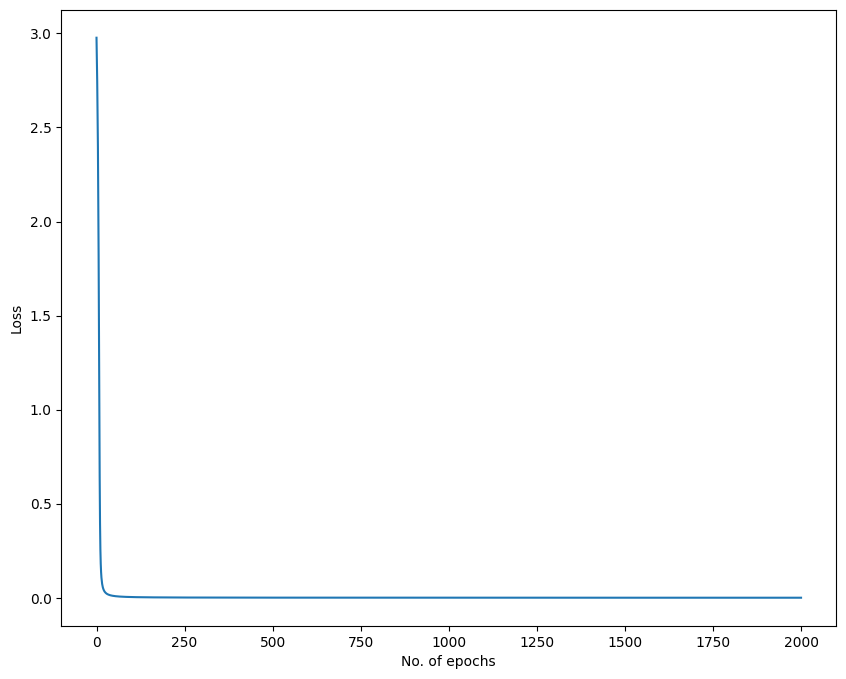

In [23]:
import torch.optim as optim

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = torch.nn.CrossEntropyLoss()  # define loss function
loss_hist = []  # list to store loss values, to plot at the end

# Initialize data and labels
train_data = get_input_tensor(torch.tensor(train_emb.Input.values.astype(int)), vocab_size)

train_labels = torch.tensor(train_emb.Output.values, dtype=torch.long)  # Should be a 1D tensor of the indexes of the neighbor words expected

# Move tensors to device
train_data = train_data.to(device)
train_labels = train_labels.to(device, dtype=torch.long)  # Ensure train_labels is of type long

assert train_data.shape == (train_emb.shape[0], vocab_size)
assert train_labels.shape == (train_emb.shape[0],)

# Move model to device
skipgram_model.to(device)

optimizer = optim.SGD(skipgram_model.parameters(), lr=learning_rate)

for epo in range(num_epochs):
    # Forward pass
    predictions = skipgram_model(train_data)

    # Compute loss
    loss = loss_fn(predictions, train_labels)

    # Reset gradients
    optimizer.zero_grad()

    # Backpropagation step
    loss.backward()

    # Update weights using gradient descent
    optimizer.step()

    loss_hist.append(loss.item())

    # Print the loss every 250 epochs
    if epo % 250 == 0:
        print(f'Epoch {epo}, loss = {loss}')

plt.plot(loss_hist)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.show()


In [24]:
# Access the tensor containing the weights of the first hidden layer
W1_tensor = skipgram_model[0].weight.data

# Detach the tensor to create a copy and convert it to a NumPy ndarray
W1 = W1_tensor.detach().numpy()

# Transpose the matrix to match the expected shape
W1 = W1.T

assert isinstance(W1, np.ndarray) and W1.shape == (vocab_size, embed_dims)


# Using SVD to reduce 4D to 2D 

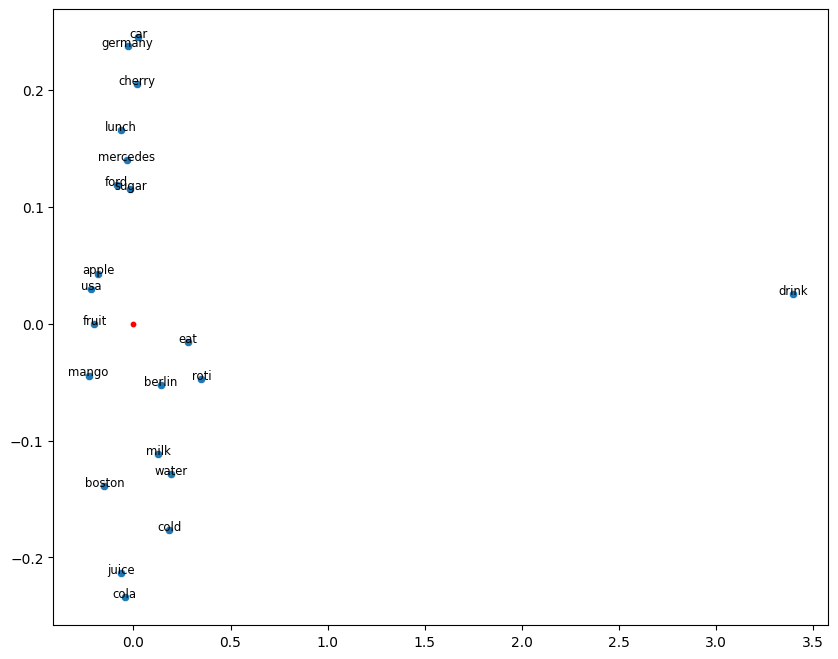

In [25]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1) #Now a 21 x 2 matrix

# Just like we saw in the original W1, each row is
# a word embedding, i.e a given column contains the
# components of every word embedding along a certain "direction"
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

# Red dot on the origin
plot.scatter(x=0, y=0, color='r',s=10)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i], list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='normal');

In [28]:
def get_embeddings(word):
    # Get the 4D and 2D representations corresponding to the word
    # using vocabulary, W1 and W1_dec
    index = vocabulary[word]
    vec_4d = W1[index].reshape(1, -1)  # Reshape to ensure a 2D array
    vec_2d = W1_dec[index].reshape(1, -1)  # Reshape to ensure a 2D array
    return vec_4d, vec_2d


# Comparing using Cosine Similarity


In [29]:
# <START>
word1 = 'cherry'
word2 = 'apple'
# <END>

assert vocabulary[word1] is not None and vocabulary[word2] is not None

word1_4d, word1_2d = get_embeddings(word1)
word2_4d, word2_2d = get_embeddings(word2)

print(f'Cosine similarity of {word1} and {word2}:')
print('4D: {:.3f}'.format(cosine_similarity(word1_4d, word2_4d)[0, 0]))
print('2D: {:.3f}'.format(cosine_similarity(word1_2d, word2_2d)[0, 0]))


Cosine similarity of cherry and apple:
4D: -0.033
2D: 0.140


In [30]:
def closest_neighbors(word):
    # Get the embeddings for the input word
    word_4d, word_2d = get_embeddings(word)

    # Initialize variables to store the most similar word and its similarity score
    most_similar_word_4d = None
    most_similar_word_2d = None
    max_similarity_4d = -1
    max_similarity_2d = -1

    # Iterate over the vocabulary to find the most similar word
    for w in vocabulary:
        if w == word:
            continue  # Skip the input word itself

        # Get the embeddings for the current word
        w_4d, w_2d = get_embeddings(w)

        # Compute cosine similarity between the input word and the current word embeddings
        sim_4d = cosine_similarity(word_4d, w_4d)[0, 0]
        sim_2d = cosine_similarity(word_2d, w_2d)[0, 0]

        # Update most similar word and similarity score if the current word has higher similarity
        if sim_4d > max_similarity_4d:
            most_similar_word_4d = w
            max_similarity_4d = sim_4d

        if sim_2d > max_similarity_2d:
            most_similar_word_2d = w
            max_similarity_2d = sim_2d

    # Print the results
    print(f'Most similar word to {word} (4D): {most_similar_word_4d} (Similarity: {max_similarity_4d:.3f})')
    print(f'Most similar word to {word} (2D): {most_similar_word_2d} (Similarity: {max_similarity_2d:.3f})')


In [31]:
for w in vocabulary.keys():
  closest_neighbors(w)

Most similar word to drink (4D): roti (Similarity: 0.980)
Most similar word to drink (2D): eat (Similarity: 0.998)
Most similar word to milk (4D): water (Similarity: 0.919)
Most similar word to milk (2D): cold (Similarity: 0.999)
Most similar word to cold (4D): water (Similarity: 0.808)
Most similar word to cold (2D): milk (Similarity: 0.999)
Most similar word to water (4D): berlin (Similarity: 0.936)
Most similar word to water (2D): milk (Similarity: 0.991)
Most similar word to cola (4D): juice (Similarity: 0.870)
Most similar word to cola (2D): juice (Similarity: 0.995)
Most similar word to juice (4D): cola (Similarity: 0.870)
Most similar word to juice (2D): cola (Similarity: 0.995)
Most similar word to eat (4D): drink (Similarity: 0.863)
Most similar word to eat (2D): drink (Similarity: 0.998)
Most similar word to roti (4D): drink (Similarity: 0.980)
Most similar word to roti (2D): eat (Similarity: 0.997)
Most similar word to lunch (4D): mercedes (Similarity: 0.993)
Most similar wo